In [20]:
import sctop as top
import pandas as pd
from taigapy import create_taiga_client_v3
import numpy as np
import io
import os
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(2024)

tc = create_taiga_client_v3()

class OrderParamClassifier:
    def __init__(self, expr, markers, num_samples): 
        """

        :param expr: Expression data.
            Format: Pandas DataFrame.
            Rows: samples (index)
            Columns: genes (ensg).
            Entries: log2(tpm+1)
        :param markers: Cell types
            Format: Pandas Series
            Rows: samples (index)
            Columns: metadata
            Entries: plain text. at least one cell/disease type column
        :param num_samples: Int. Number of samples to take from each marker for training

        """
        self.expr = expr
        self.markers = markers
        self.num_samples= num_samples
        self.basis = pd.DataFrame()

        self.harmonize_samples()

    def load_expr(self):
        pass

    def load_meta(self):
        pass

    def harmonize_samples(self):
        marker_counts = self.markers.value_counts()
        valid_markers = marker_counts[marker_counts > self.num_samples].index
        self.markers = self.markers[self.markers.isin(valid_markers)]

        shared_idxs = self.expr.index.intersection(self.markers.index)
        self.expr = self.expr.loc[shared_idxs]
        self.markers = self.markers.loc[shared_idxs]

    def train(self):
        expr_list = []
        train_ids = []

        labels = self.markers.unique().tolist()

        for curr_type in labels:
            curr_type_ids = self.markers[self.markers == curr_type].index
            train_sample = rng.choice(curr_type_ids, self.num_samples, replace=False)
            train_ids += [train_sample]

            curr_expr = self.expr.loc[train_sample]
            curr_processed = top.process(2 ** curr_expr.T - 1, average=True)
            expr_list.append(curr_processed)

        train_ids = np.concatenate(train_ids)
        self.basis = pd.concat(expr_list, axis=1)
        self.basis.columns = labels
        self.basis.index = self.basis.index.rename('gene')

        accuracies, test_labels = self.validate_training(train_ids)
        return train_ids, accuracies, test_labels

    def score(self, test_data):
        processed = top.process(2 ** test_data.T - 1)
        projections, _, eta = top.score(self.basis, processed, full_output=True)
        return projections, eta

    def validate_training(self, train_ids):
        test_ids = self.markers.index.difference(self.markers.loc[train_ids].index)
        projections, eta = self.score(self.expr.loc[test_ids])

        return self.check_acc(projections)

    def check_acc(self, projections, skip_fun=None, specification_value=0.1):
        if not skip_fun:
            def skip_fun(sample, ann):
                return False

        accuracies = {'top1': 0,
                      'top3': 0,
                      'unspecified': 0
                      }

        num_tested = 0

        labels = []

        for sample_id, sample_projections in projections.iteritems():

            types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
            true_type = self.markers.loc[sample_id]

            if skip_fun(sample_id, self.markers):
                continue

            num_tested += 1

            top_type = types_sorted_by_projections[0]

            if sample_projections.max() < specification_value:
                accuracies['unspecified'] += 1

            if top_type == true_type:
                accuracies['top1'] += 1
            if true_type in types_sorted_by_projections[:3]:
                accuracies['top3'] += 1

            true_idx_tup = (true_type, true_type, true_type)
            label_df = pd.DataFrame(data=true_idx_tup, columns=['true_type'])
            label_df['labeled_type'] = types_sorted_by_projections[:3]
            label_df.index.name = 'place'
            labels.append(label_df.reset_index())

        print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(num_tested,
                                                                                                       self.num_samples))

        for key, value in accuracies.items():
            print('{}: {:.2f}%'.format(key, 100 * value / num_tested))

        return accuracies, pd.concat(labels, ignore_index=True)

def get_gene_map(tc):
    hgnc = tc.get(name='hgnc-87ab', version=7, file='hgnc_complete_set')
    hgnc = hgnc[['hgnc_id', 'symbol', 'locus_group', 'locus_type','entrez_id', 'ensembl_gene_id']]
    hgnc['depmap'] = hgnc.symbol + ' (' + hgnc.entrez_id.fillna(-1).astype(int).astype(str) + ')'
    hgnc.loc[(hgnc.symbol.isna()) | (hgnc.entrez_id.isna()),'depmap'] = np.nan
    #ensembl = generateGeneNames(attributes=['ensembl_transcript_id'])
    #hgnc['ensembl_transcript_id'] = pd.merge(hgnc.ensembl_gene_id,ensembl.set_index('ensembl_gene_id').ensembl_transcript_id)
    return hgnc


oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")
oncotree=oncotree.reset_index()

# Step 1: Find names with more than one unique OncoTree code
multiple_codes = oncotree.groupby('name')['code'].nunique()
names_with_multiple_codes = multiple_codes[multiple_codes > 1].index

# Step 2: Update the 'name' column in the oncotree DataFrame
def update_name(row):
    if row['name'] in names_with_multiple_codes:
        return f"{row['name']} ({row['tissue']})"
    return row['name']
oncotree['name'] = oncotree.apply(update_name, axis=1)  
ocotree=oncotree.set_index('code')

def get_sublineage(code, oncotree):
    """
    Takes an Oncotree code and returns the node on the Oncotree that is just below the lineage level.
    
    Parameters:
    - code (str): The Oncotree code for which to find the sublineage node.
    - oncotree (pd.DataFrame): A DataFrame with Oncotree data where 'code' is the index and includes 'name' and 'parent' columns.
    
    Returns:
    - str: The name of the node just below the lineage level.
    
    
    """
    node = oncotree.loc[code]
    while oncotree.loc[node.parent].tissue != oncotree.loc[node.parent]['name']:
        node = oncotree.loc[node.parent]
    return node['name']
    
def code_from_subtype(s, oncotree):
    """
    Fills in Oncotree codes for samples where the Oncotree code is blank based on subtype names.
    
    Parameters:
    - s (str or None): The subtype name for which to find the Oncotree code.
    - oncotree (pd.DataFrame): A DataFrame with Oncotree data where 'name' is a column, and 'code' is the index.
    
    Returns:
    - str or np.nan: The Oncotree code corresponding to the subtype name, or NaN if no match is found.
    
    """
    if s is None:
        return np.nan
    matches = oncotree[oncotree['name'].str.lower() == s.lower()]
    if len(matches) > 0:
        return matches.index[0]
    else:
        return np.nan



def process_oncocode(code, oncotree):
    """
    Generates a disease annotation given an Oncotree code.
    
    Parameters:
    - code (str): Oncotree code.
    - oncotree (pd.DataFrame): A DataFrame with Oncotree data where 'code' is the index.
    
    Returns:
    - pd.Series: A Series containing the disease lineage and subtype associated with the Oncotree code.
      Returns NaN for both fields if the code is not found.
    
    """
    if code in oncotree.index:
        row = oncotree.loc[code]
        return pd.Series({"lineage": row.tissue, "subtype": row["name"]})
    else:
        return pd.Series({"lineage": np.nan, "subtype": np.nan})

def get_subtype(oncotree):
    """
    Gets a list of unique subtypes from the Oncotree DataFrame.
    
    Parameters:
    - oncotree (pd.DataFrame): A DataFrame with Oncotree data, which should include a 'name' column.
    
    Returns:
    - list: A list of unique subtypes, converted to lowercase.
    
    """
    subtypes = oncotree['name'].unique()
    subtypes = pd.Series(subtypes)
    return subtypes.str.lower().unique().tolist()

def get_tcga_classifier(num_samples):
    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    tcga_ann = tc.get('celligner-input-9827.7/tumor_annotations').set_index('sampleID').oncotree_lineage #tree of diferent cancer types
    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier


def get_gtext_classifier():
    pass



def generateGeneNames(
    ensemble_server="http://nov2020.archive.ensembl.org/biomart",
    useCache=False,
    cache_folder='/home/ubuntu/Documents/data/ensemblcache/',
    attributes=[],
    default_attr=[
        "ensembl_gene_id",
        "clone_based_ensembl_gene",
        "hgnc_symbol",
        "gene_biotype",
        "entrezgene_id",
    ],
):
    """generate a genelist dataframe from ensembl's biomart

    Args:
        ensemble_server ([type], optional): [description]. Defaults to ENSEMBL_SERVER_V.
        useCache (bool, optional): [description]. Defaults to False.
        cache_folder ([type], optional): [description]. Defaults to CACHE_PATH.

    Raises:
        ValueError: [description]

    Returns:
        [type]: [description]
    """
    assert cache_folder[-1] == "/"

    cache_folder = os.path.expanduser(cache_folder)
    createFoldersFor(cache_folder)
    cachefile = os.path.join(cache_folder, ".biomart.csv")
    if useCache & os.path.isfile(cachefile):
        print("fetching gene names from biomart cache")
        res = pd.read_csv(cachefile)
    else:
        print("downloading gene names from biomart")
        res = _fetchFromServer(ensemble_server, default_attr + attributes)
        res.to_csv(cachefile, index=False)

    res.columns = default_attr + attributes
    if type(res) is not type(pd.DataFrame()):
        raise ValueError("should be a dataframe")

    if "clone_based_ensembl_gene" in default_attr and "hgnc_symbol" in default_attr:
        res = res[~(res["clone_based_ensembl_gene"].isna() & res["hgnc_symbol"].isna())]
        res.loc[res[res.hgnc_symbol.isna()].index, "hgnc_symbol"] = res[
            res.hgnc_symbol.isna()
        ]["clone_based_ensembl_gene"]

    return res

def createFoldersFor(filepath):
    """
    will recursively create folders if needed until having all the folders required to save the file in this filepath
    """
    prevval = ""
    for val in os.path.expanduser(filepath).split("/")[:-1]:
        prevval += val + "/"
        if not os.path.exists(prevval):
            os.mkdir(prevval)

def _fetchFromServer(ensemble_server, attributes):
    # deferring the import until last possible moment because it's unclear
    # to me whether we are actually fetching data from biomart. (I don't think we should)
    from biomart import BiomartServer

    server = BiomartServer(ensemble_server)
    ensmbl = server.datasets["hsapiens_gene_ensembl"]
    res = pd.read_csv(
        io.StringIO(
            ensmbl.search({"attributes": attributes}, header=1).content.decode()
        ),
        sep="\t",
    )
    return res


In [21]:
oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")
oncotree=oncotree.reset_index()

# Step 1: Find names with more than one unique OncoTree code
multiple_codes = oncotree.groupby('name')['code'].nunique()
names_with_multiple_codes = multiple_codes[multiple_codes > 1].index

# Step 2: Update the 'name' column in the oncotree DataFrame
def update_name(row):
    if row['name'] in names_with_multiple_codes:
        return f"{row['name']} ({row['tissue']})"
    return row['name']
oncotree['name'] = oncotree.apply(update_name, axis=1)  
ocotree=oncotree.set_index('code')


In [27]:
tcga_meta = tc.get('celligner-input-9827.10/tumor_annotations')
# Fill missing Oncotree codes based on subtype
tcga_meta.loc[tcga_meta.oncotree_code.isna(), 'oncotree_code'] = (
    tcga_meta[tcga_meta.oncotree_code.isna()]
    .subtype
    .apply(lambda x: code_from_subtype(x, oncotree))
)

# Assign derived lineage and subtype based on the Oncotree code
tcga_meta[['derived_lineage', 'derived_subtype']] = (
    tcga_meta.oncotree_code
    .apply(lambda x: process_oncocode(x, oncotree))
    .rename(columns={'lineage': 'derived_lineage', 'subtype': 'derived_subtype'})
)

In [48]:
tcga_meta.to_csv('/Users/nabdirah/Project1/1stTCGA.csv') # tcga with new columns:derived_subtype and derived_lineage 

In [29]:
tcga_meta['derived_subtype'].isna().mean()

0.05794377247466492

In [30]:
num_samples = 25 
classifier = get_tcga_classifier(num_samples) 

In [ ]:
classifier.train()

In [ ]:
#tcga_meta.to_csv('/Users/nabdirah/Project1/realtcga.csv')

In [32]:

def get_correlation(filtered_data):
    """
    Calculates the correlation matrix for a subset of samples.
    
    Parameters:
    - filtered_data (pd.DataFrame): A DataFrame containing filtered sample data with 'sampleID'.
    
    Returns:
    - pd.DataFrame: A correlation matrix for the subset of samples.
    
   
    """
    correlation = classifier.expr.loc[filtered_data['sampleID']].T.corr()
    return correlation


def get_pair(correlationdata, filtereddata, subtypes):
    """
    Generates pairs of subtypes and calculates their correlation comparisons.
    
    Parameters:
    - correlationdata (pd.DataFrame): The correlation matrix for samples.
    - filtereddata (pd.DataFrame): The DataFrame with filtered sample data and subtype information.
    - subtypes (list): List of subtypes to be compared.
    
    Returns:
    - list: A list of tuples where each tuple contains a pair of subtypes, their correlation comparisons,
      and the number of samples for each subtype.
    
    """
    subtype_pairs = []
    # between pairs
    for i, subtype1 in enumerate(subtypes):
        for subtype2 in subtypes[i+1:]:
            samples1 = filtereddata[filtereddata['derived_subtype'] == subtype1]['sampleID']
            samples2 = filtereddata[filtereddata['derived_subtype'] == subtype2]['sampleID']
            comparison = correlationdata.loc[samples1, samples2]
            n_samples1 = len(samples1)
            n_samples2 = len(samples2)
            subtype_pairs.append((subtype1, subtype2, comparison, n_samples1, n_samples2))
    
    # within-subtype
    for subtype in subtypes:
        samples = filtereddata[filtereddata['derived_subtype'] == subtype]['sampleID']
        comparison = correlationdata.loc[samples, samples]
        n_samples = len(samples)
        subtype_pairs.append((subtype, subtype, comparison, n_samples, n_samples))

    return subtype_pairs


def get_pair_stat(subtype_pairs, correlationdata, filtereddata):
    """
    Calculates statistics for each pair of subtypes.
    
    Parameters:
    - subtype_pairs (list): A list of tuples containing subtype pairs and their correlation comparisons.
    - correlationdata (pd.DataFrame): The correlation matrix for samples.
    - filtereddata (pd.DataFrame): The DataFrame with filtered sample data and subtype information.
    
    Returns:
    - pd.DataFrame: A DataFrame with statistics for each pair of subtypes, including median correlation,
      average expression correlation, and the number of samples.
    
    """
    results = []
    
    for subtype1, subtype2, comparison, n_samples1, n_samples2 in subtype_pairs:
        if not comparison.empty:
            if subtype1 == subtype2:
                tril = np.tril_indices(len(comparison), -1)
                median_corr = np.median(comparison.to_numpy()[tril])
            else:
                median_corr = np.median(comparison.to_numpy().flatten())
            
            avg_expr1 = classifier.expr.loc[filtereddata[filtereddata['derived_subtype'] == subtype1]['sampleID']].mean()
            avg_expr2 = classifier.expr.loc[filtereddata[filtereddata['derived_subtype'] == subtype2]['sampleID']].mean()
            avg_expr_corr = avg_expr1.corr(avg_expr2)
            
            results.append((subtype1, subtype2, median_corr, avg_expr_corr, n_samples1, n_samples2))
        else:
            results.append((subtype1, subtype2, float('nan'), float('nan'), n_samples1, n_samples2))

    return pd.DataFrame(results, columns=['col1', 'col2', 'median_correlation', 'avg_expr_correlation', 'n_samples1', 'n_samples2'])


In [33]:
tcga_meta.derived_lineage.unique()

array(['CNS/Brain', 'Bowel', 'Myeloid', 'Esophagus/Stomach', 'Pleura',
       'Skin', 'Lung', 'Testis', 'Soft Tissue', 'Kidney', 'Liver',
       'Prostate', 'Uterus', 'Breast', 'Head and Neck', 'Cervix',
       'Ovary/Fallopian Tube', 'Thymus', 'Thyroid',
       'Bladder/Urinary Tract', 'Pancreas', 'Adrenal Gland', 'Eye',
       'Biliary Tract', 'Lymphoid', 'Peripheral Nervous System', nan,
       'Bone'], dtype=object)

In [34]:
def get_lineage_df(lineage, tcga_meta, expr):
    """
    Processes and analyzes data for a specific lineage to compute correlation statistics.

    Parameters:
    - lineage (str): The lineage to filter the data by.
    - tcga_meta (pd.DataFrame): The metadata DataFrame containing information about samples, including 'derived_lineage' and 'sampleID'.
    - expr (pd.DataFrame): The expression data with samples as rows and features as columns.

    Returns:
    - pd.DataFrame: A DataFrame containing statistics for each subtype pair within the specified lineage.
    """

    print("Initial filtered data")

    # Filter data for the specified lineage
    print(f"Filtered data for lineage {lineage}")
    filtered_data = tcga_meta[tcga_meta.derived_lineage == lineage]
    
    # Find valid sample IDs that are present in the expression data
    valid_ids = expr.index.intersection(pd.Index(filtered_data['sampleID']))
    print(f"Valid IDs: {len(valid_ids)}")

    # Further filter data to include only rows with valid sample IDs
    print(f"Filtered data with valid IDs for lineage {lineage}")
    filtered_data = filtered_data.loc[filtered_data['sampleID'].isin(valid_ids)]

    # Compute the correlation matrix for the filtered data
    print(f"Correlation data for lineage {lineage}")
    correlation_data = get_correlation(filtered_data)
    
    # Generate subtype pairs and calculate correlation statistics
    pairs = get_pair(correlation_data, filtered_data, filtered_data.derived_subtype.unique().tolist())
    print(f"Pairs for lineage {lineage}: {len(pairs)}")
    
    # Compute statistical measures for the pairs
    tumor = get_pair_stat(pairs, correlation_data, filtered_data)
    print(f"Tumor stats for lineage {lineage}")
    
    return pd.DataFrame(tumor)


In [ ]:
#tcga_meta=pd.read_csv('/Users/nabdirah/Project1/lineage_tcga.csv')

In [35]:
lineage_dfs=[]
for lineage in tcga_meta.derived_lineage.unique():
    lineage_df = get_lineage_df(lineage,tcga_meta,classifier.expr)
    lineage_dfs.append(lineage_df)

Initial filtered data
Filtered data for lineage CNS/Brain
Valid IDs: 977
Filtered data with valid IDs for lineage CNS/Brain
Correlation data for lineage CNS/Brain
Pairs for lineage CNS/Brain: 105


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid valu

Tumor stats for lineage CNS/Brain
Initial filtered data
Filtered data for lineage Bowel
Valid IDs: 384
Filtered data with valid IDs for lineage Bowel
Correlation data for lineage Bowel
Pairs for lineage Bowel: 10
Tumor stats for lineage Bowel
Initial filtered data
Filtered data for lineage Myeloid
Valid IDs: 560
Filtered data with valid IDs for lineage Myeloid
Correlation data for lineage Myeloid
Pairs for lineage Myeloid: 10


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Myeloid
Initial filtered data
Filtered data for lineage Esophagus/Stomach
Valid IDs: 595
Filtered data with valid IDs for lineage Esophagus/Stomach
Correlation data for lineage Esophagus/Stomach
Pairs for lineage Esophagus/Stomach: 45
Tumor stats for lineage Esophagus/Stomach
Initial filtered data
Filtered data for lineage Pleura
Valid IDs: 87
Filtered data with valid IDs for lineage Pleura
Correlation data for lineage Pleura
Pairs for lineage Pleura: 6
Tumor stats for lineage Pleura
Initial filtered data
Filtered data for lineage Skin
Valid IDs: 467
Filtered data with valid IDs for lineage Skin
Correlation data for lineage Skin
Pairs for lineage Skin: 6


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Skin
Initial filtered data
Filtered data for lineage Lung
Valid IDs: 1015
Filtered data with valid IDs for lineage Lung
Correlation data for lineage Lung
Pairs for lineage Lung: 6


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Lung
Initial filtered data
Filtered data for lineage Testis
Valid IDs: 154
Filtered data with valid IDs for lineage Testis
Correlation data for lineage Testis
Pairs for lineage Testis: 21
Tumor stats for lineage Testis
Initial filtered data
Filtered data for lineage Soft Tissue
Valid IDs: 422
Filtered data with valid IDs for lineage Soft Tissue
Correlation data for lineage Soft Tissue
Pairs for lineage Soft Tissue: 136


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid valu

Tumor stats for lineage Soft Tissue
Initial filtered data
Filtered data for lineage Kidney
Valid IDs: 1012
Filtered data with valid IDs for lineage Kidney
Correlation data for lineage Kidney
Pairs for lineage Kidney: 10
Tumor stats for lineage Kidney
Initial filtered data
Filtered data for lineage Liver
Valid IDs: 391
Filtered data with valid IDs for lineage Liver
Correlation data for lineage Liver
Pairs for lineage Liver: 6
Tumor stats for lineage Liver
Initial filtered data
Filtered data for lineage Prostate
Valid IDs: 496
Filtered data with valid IDs for lineage Prostate
Correlation data for lineage Prostate
Pairs for lineage Prostate: 1
Tumor stats for lineage Prostate
Initial filtered data
Filtered data for lineage Uterus
Valid IDs: 238
Filtered data with valid IDs for lineage Uterus
Correlation data for lineage Uterus
Pairs for lineage Uterus: 15


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Uterus
Initial filtered data
Filtered data for lineage Breast
Valid IDs: 1092
Filtered data with valid IDs for lineage Breast
Correlation data for lineage Breast
Pairs for lineage Breast: 21


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Breast
Initial filtered data
Filtered data for lineage Head and Neck
Valid IDs: 526
Filtered data with valid IDs for lineage Head and Neck
Correlation data for lineage Head and Neck
Pairs for lineage Head and Neck: 6
Tumor stats for lineage Head and Neck
Initial filtered data
Filtered data for lineage Cervix
Valid IDs: 304
Filtered data with valid IDs for lineage Cervix
Correlation data for lineage Cervix
Pairs for lineage Cervix: 10
Tumor stats for lineage Cervix
Initial filtered data
Filtered data for lineage Ovary/Fallopian Tube
Valid IDs: 426
Filtered data with valid IDs for lineage Ovary/Fallopian Tube
Correlation data for lineage Ovary/Fallopian Tube
Pairs for lineage Ovary/Fallopian Tube: 1
Tumor stats for lineage Ovary/Fallopian Tube
Initial filtered data
Filtered data for lineage Thymus
Valid IDs: 121
Filtered data with valid IDs for lineage Thymus
Correlation data for lineage Thymus
Pairs for lineage Thymus: 3
Tumor stats for lineage Thymus
Initial fil

/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Thyroid
Initial filtered data
Filtered data for lineage Bladder/Urinary Tract
Valid IDs: 407
Filtered data with valid IDs for lineage Bladder/Urinary Tract
Correlation data for lineage Bladder/Urinary Tract
Pairs for lineage Bladder/Urinary Tract: 1
Tumor stats for lineage Bladder/Urinary Tract
Initial filtered data
Filtered data for lineage Pancreas
Valid IDs: 178
Filtered data with valid IDs for lineage Pancreas
Correlation data for lineage Pancreas
Pairs for lineage Pancreas: 1
Tumor stats for lineage Pancreas
Initial filtered data
Filtered data for lineage Adrenal Gland
Valid IDs: 243
Filtered data with valid IDs for lineage Adrenal Gland
Correlation data for lineage Adrenal Gland
Pairs for lineage Adrenal Gland: 6


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tumor stats for lineage Adrenal Gland
Initial filtered data
Filtered data for lineage Eye
Valid IDs: 81
Filtered data with valid IDs for lineage Eye
Correlation data for lineage Eye
Pairs for lineage Eye: 3
Tumor stats for lineage Eye
Initial filtered data
Filtered data for lineage Biliary Tract
Valid IDs: 37
Filtered data with valid IDs for lineage Biliary Tract
Correlation data for lineage Biliary Tract
Pairs for lineage Biliary Tract: 6
Tumor stats for lineage Biliary Tract
Initial filtered data
Filtered data for lineage Lymphoid
Valid IDs: 350
Filtered data with valid IDs for lineage Lymphoid
Correlation data for lineage Lymphoid
Pairs for lineage Lymphoid: 6
Tumor stats for lineage Lymphoid
Initial filtered data
Filtered data for lineage Peripheral Nervous System
Valid IDs: 196
Filtered data with valid IDs for lineage Peripheral Nervous System
Correlation data for lineage Peripheral Nervous System
Pairs for lineage Peripheral Nervous System: 6
Tumor stats for lineage Peripheral Ne

In [36]:
df_subtypes = pd.concat(lineage_dfs)
lineage_mapping = tcga_meta[['derived_subtype', 'derived_lineage']].drop_duplicates()
table = pd.merge(df_subtypes, lineage_mapping, left_on='col1', right_on='derived_subtype', how='left')


In [39]:
table.derived_lineage.unique()

array(['CNS/Brain', 'Bowel', 'Myeloid', 'Esophagus/Stomach', 'Pleura',
       'Skin', 'Lung', 'Testis', 'Soft Tissue', 'Kidney', 'Liver',
       'Prostate', 'Uterus', 'Breast', 'Head and Neck', 'Cervix',
       'Ovary/Fallopian Tube', 'Thymus', 'Thyroid',
       'Bladder/Urinary Tract', 'Pancreas', 'Adrenal Gland', 'Eye',
       'Biliary Tract', 'Lymphoid', 'Peripheral Nervous System', 'Bone'],
      dtype=object)

In [47]:
file='lineagecorrelation.csv'
table.to_csv(file, index=False)
print(f"DataFrame has been written to {file}")

DataFrame has been written to lineagecorrelation.csv


In [40]:
test_sample_counts = table['derived_subtype'].value_counts().reset_index()
test_sample_counts.columns = ['derived_subtype', 'Num_Test_Samples']

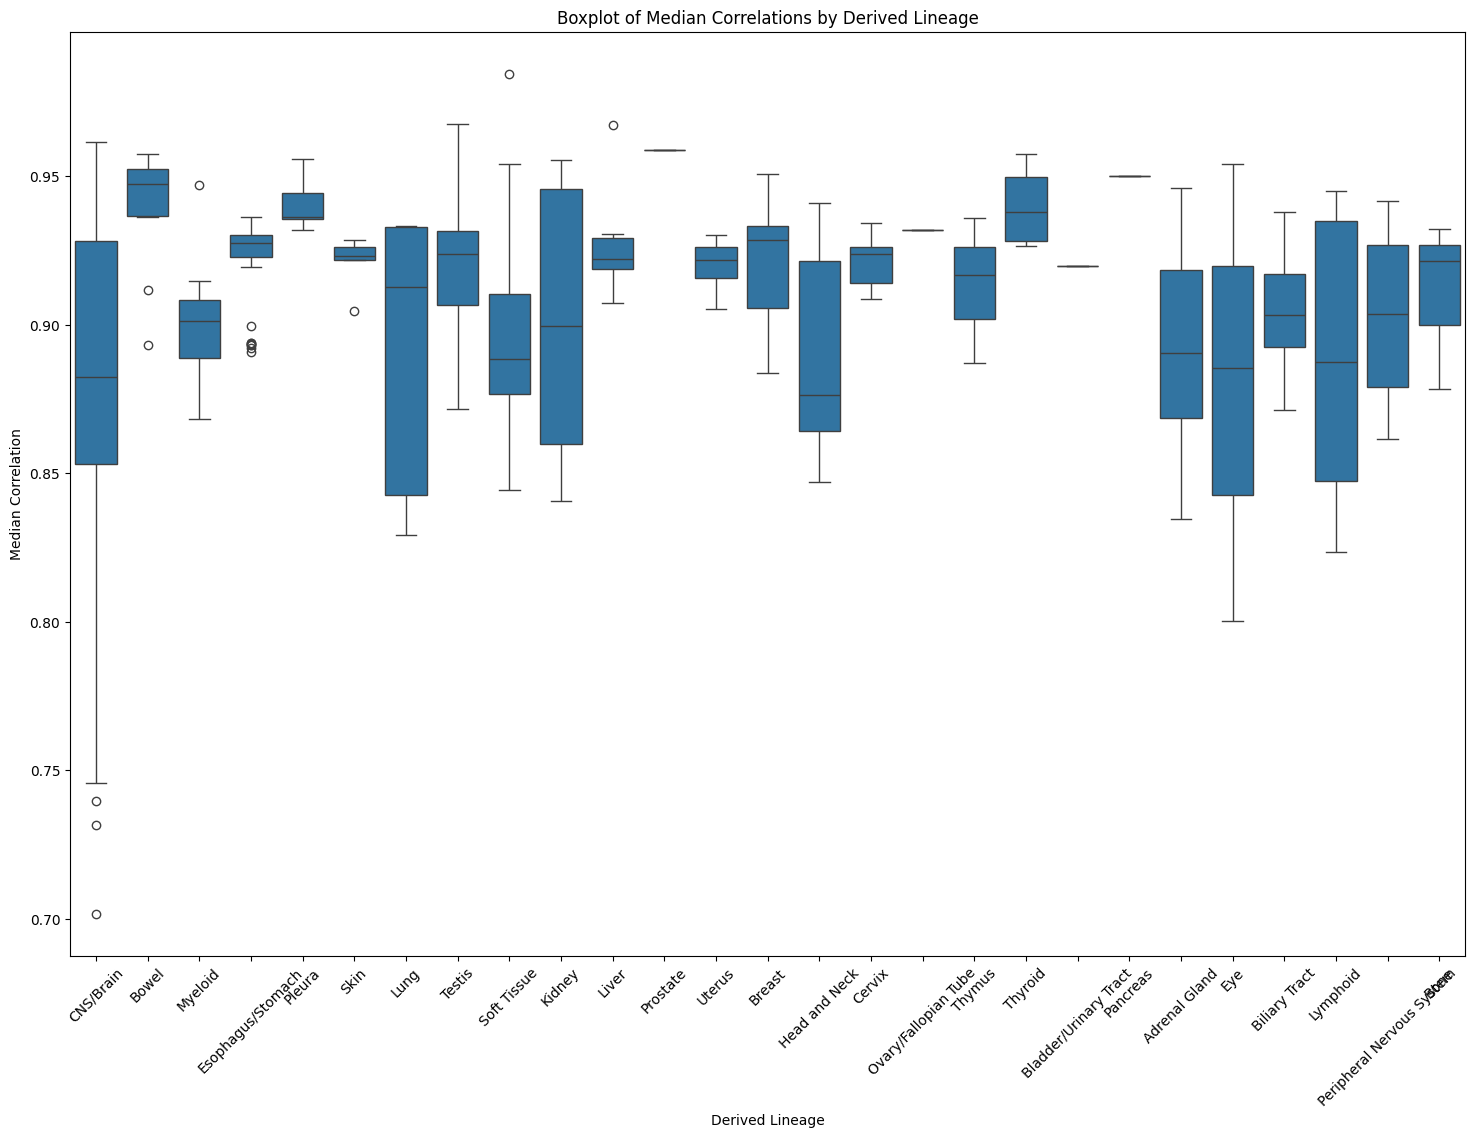

In [42]:
#generates a boxplot to visualize the distribution of median correlation values for different derived lineages.
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))
sns.boxplot(x='derived_lineage', y='median_correlation', data=table)
plt.title('Boxplot of Median Correlations by Derived Lineage')
plt.xlabel('Derived Lineage')
plt.ylabel('Median Correlation')
plt.xticks(rotation=45)
plt.show()

In [56]:
tcga_meta.to_csv('/Users/nabdirah/Project1/adenosq.csv')

In [44]:
filtered_data=table[(table['median_correlation'] > 0.91) & (table['col1'] != table['col2'])]

high_corsubtype=[]
for lineage in filtered_data.derived_lineage.unique():
    high_corsubtype.append((lineage,filtered_data[filtered_data.derived_lineage==lineage].derived_subtype.unique()))
high_corsubtype




[('CNS/Brain',
  array(['Glioblastoma Multiforme', 'Oligodendroglioma', 'Diffuse Glioma',
         'Oligoastrocytoma', 'Low-Grade Glioma, NOS',
         'Anaplastic Oligoastrocytoma', 'Astrocytoma'], dtype=object)),
 ('Bowel',
  array(['Colon Adenocarcinoma', 'Rectal Adenocarcinoma',
         'Mucinous Adenocarcinoma of the Colon and Rectum'], dtype=object)),
 ('Esophagus/Stomach',
  array(['Tubular Stomach Adenocarcinoma',
         'Diffuse Type Stomach Adenocarcinoma', 'Stomach Adenocarcinoma',
         'Esophageal Adenocarcinoma',
         'Intestinal Type Stomach Adenocarcinoma',
         'Mucinous Stomach Adenocarcinoma',
         'Signet Ring Cell Carcinoma of the Stomach'], dtype=object)),
 ('Pleura',
  array(['Pleural Mesothelioma, Biphasic Type',
         'Pleural Mesothelioma, Epithelioid Type'], dtype=object)),
 ('Skin', array(['Cutaneous Melanoma', 'Melanoma'], dtype=object)),
 ('Lung', array(['Lung Adenocarcinoma'], dtype=object)),
 ('Testis',
  array(['Mixed Germ Cell Tum

In [45]:
subtypes_aboveThreshold= filtered_data.groupby('derived_lineage')['derived_subtype'].unique()
subtypes_aboveThreshold=pd.DataFrame(subtypes_aboveThreshold)
subtypes_aboveThreshold

,derived_subtype
derived_lineage,
Biliary Tract,[Intrahepatic Cholangiocarcinoma]
Bowel,"[Colon Adenocarcinoma, Rectal Adenocarcinoma, ..."
Breast,"[Breast Invasive Ductal Carcinoma, Breast Inva..."
CNS/Brain,"[Glioblastoma Multiforme, Oligodendroglioma, D..."
Cervix,"[Cervical Squamous Cell Carcinoma, Endocervica..."
Esophagus/Stomach,"[Tubular Stomach Adenocarcinoma, Diffuse Type ..."
Kidney,[Papillary Renal Cell Carcinoma]
Liver,"[Hepatocellular Carcinoma, Fibrolamellar Carci..."
Lung,[Lung Adenocarcinoma]


In [ ]:
table[(table.derived_lineage == 'CNS/Brain') 
& (table.col1 != table.col2) 
& ((table.col1 != 'Medulloblastoma') & (table.col2 != 'Medulloblastoma'))
& ((table.n_samples1 > 20) & (table.n_samples2 > 20))
].sort_values(by='median_correlation')

In [61]:
# getting correlation for adenoid subtypes 
adeno_subtypes = tcga_meta.dropna(subset=['derived_subtype'])

# Filter the DataFrame for subtypes that contain 'adeno' (case-insensitive)
adeno_subtypes = adeno_subtypes[adeno_subtypes['derived_subtype'].str.contains('adeno', case=False)]

# Extract the sample IDs corresponding to these subtypes
adenoid_samples = adeno_subtypes['sampleID']

# Calculate the correlation for the subset of samples in the classifier's expression data
correlation = classifier.expr.loc[adenoid_samples].T.corr()


In [68]:
adeno_subtypes['derived_lineage'].unique()

array(['Bowel', 'Esophagus/Stomach', 'Lung', 'Prostate', 'Pancreas',
       'Cervix', 'Adrenal Gland'], dtype=object)

/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


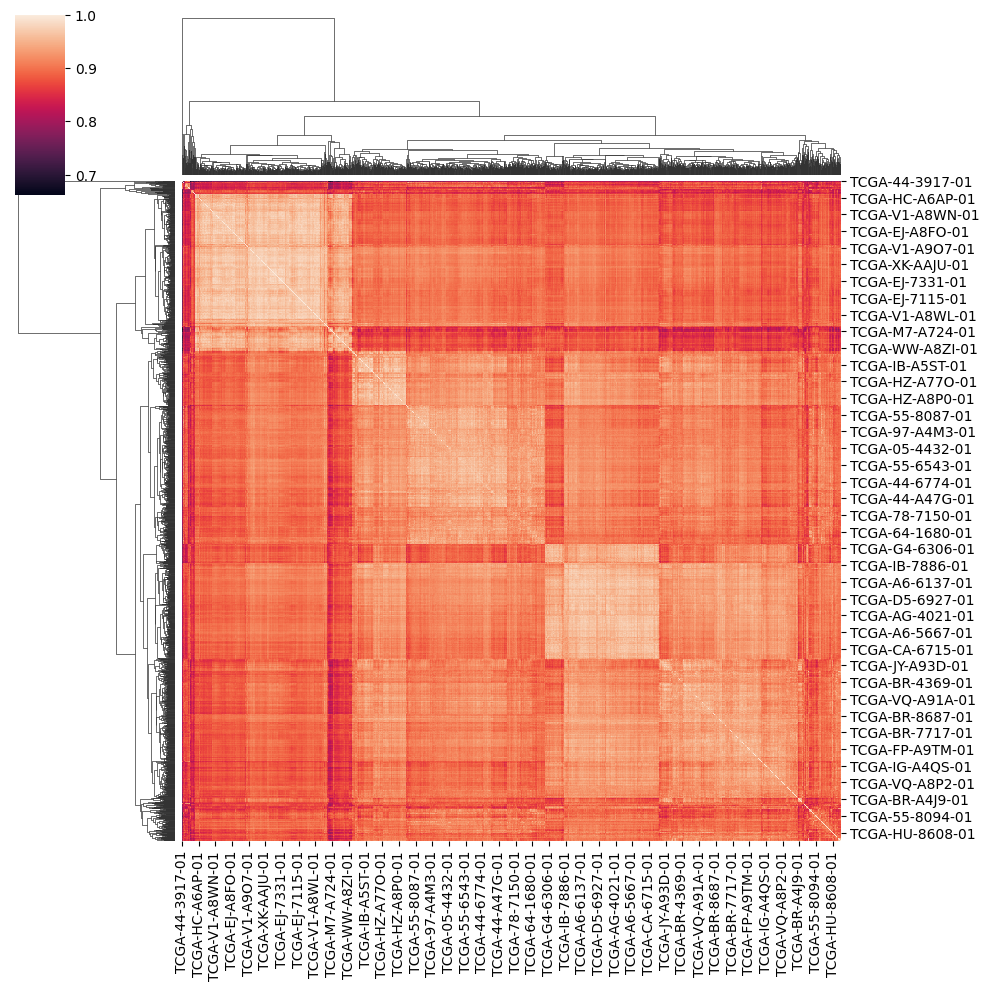

In [63]:
cluster_map=sns.clustermap(correlation)
cluster_map.savefig('correlation_clustermap.png')

In [64]:
# checking correlation for squamous subtypes 
squam_subtypes = tcga_meta.dropna(subset=['derived_subtype'])

# Filter the DataFrame for subtypes that contain 'adeno' (case-insensitive)
squam_subtypes = squam_subtypes[squam_subtypes['derived_subtype'].str.contains('adeno', case=False)]

# Extract the sample IDs corresponding to these subtypes
squamous_samples = squam_subtypes['sampleID']

# Calculate the correlation for the subset of samples in the classifier's expression data
correlation = classifier.expr.loc[squamous_samples].T.corr()